In [42]:
library(ggplot2)
library(igraph)
library(dplyr)
library(RColorBrewer)
library(progress)
library(purrr)

library(foreach)
library(doParallel)

source("simpleDynamics.R")

## Single shot dynamics

In [39]:
edge_cmap <- colorRampPalette(c("darkblue", "white"))

plotState <- function(g, edge_cmap, iteration) {
  E(g)$similarity <- edge_similarities(g)
  edge_colors <- edge_cmap(F)[cut(E(g)$similarity, breaks=F)]

  plot(g, 
    layout=layout_on_grid(g),  # Use lattice layout for proper grid representation
    vertex.size=10,  # Size of the vertices
    vertex.label=NA,  # Font size of vertex labels
    edge.color=edge_colors,  # Color of the edges
    edge.width=5,  # Size of the edges
    vertex.color="lightblue",  # Color of the vertices
    vertex.frame.color="black",  # Border color of the vertices
    vertex.label.color="black",  # Color of the vertex labels
  )
  title(paste0("i: ", iteration), cex.main=2)
}

In [42]:
# Create the (lattice) graph
L <- 10
d <- 2
g <- make_lattice(length = L, dim = d)

# Hyperparameters and initialization
F <- 10 # Number of features
q <- 4 # Disorder parameter
mode <- "pois"

g <- initialize_features(g, F, q, mode)

  |                                                                      |   0%

  |=======                                                               |  10%

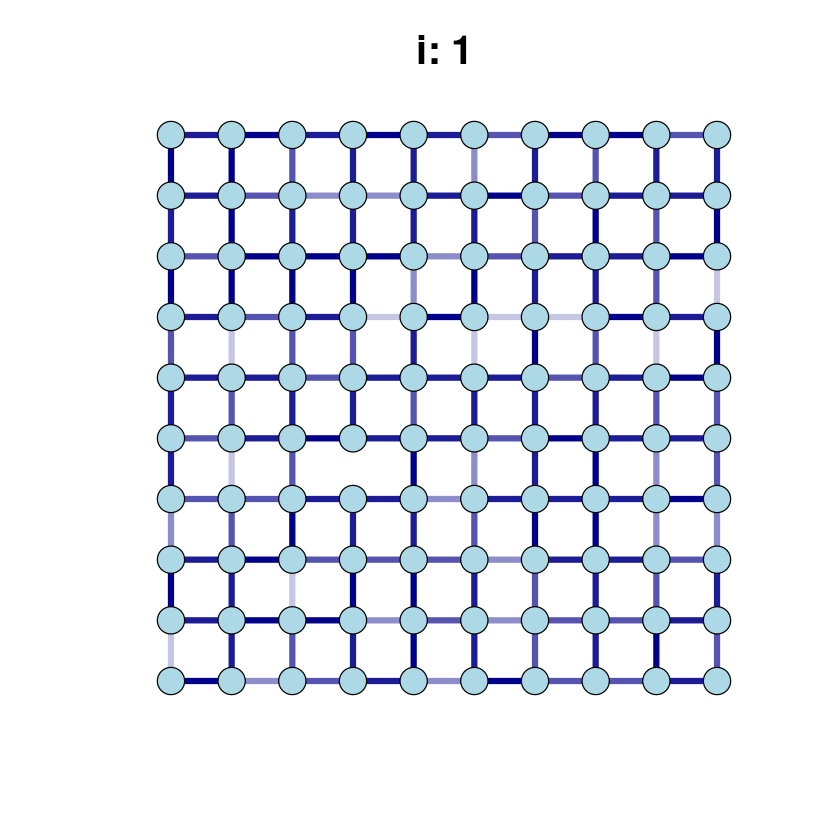

  |======================================================================| 100%

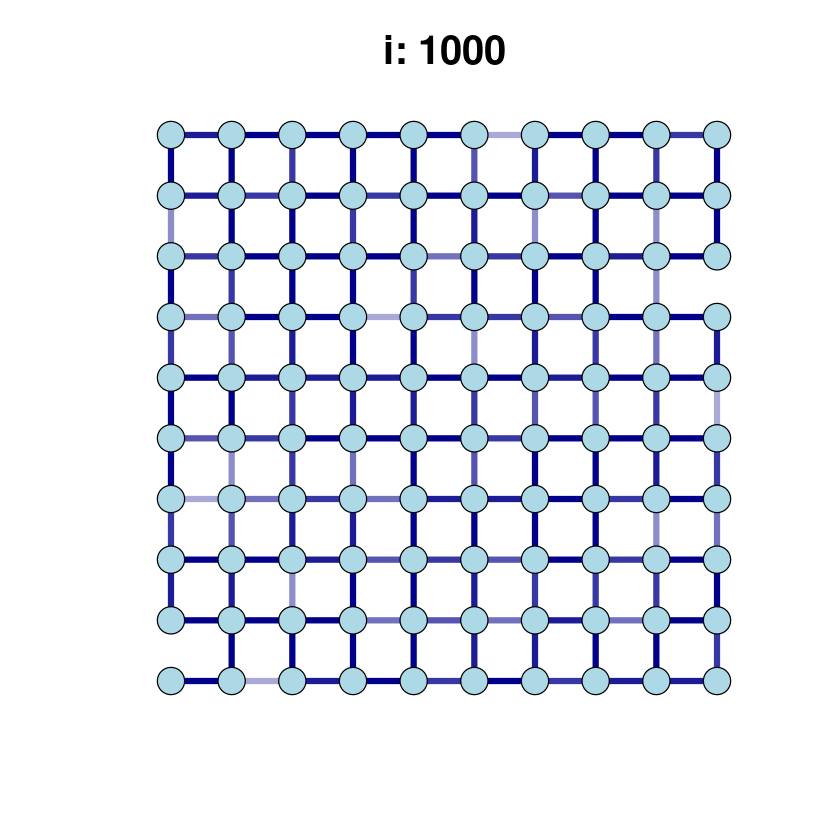

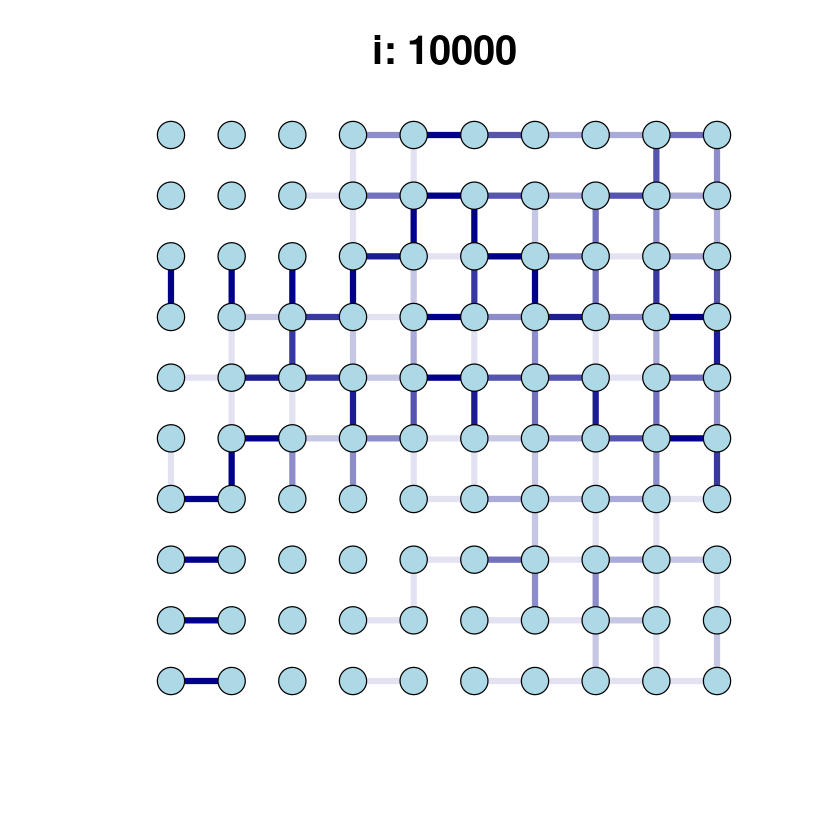

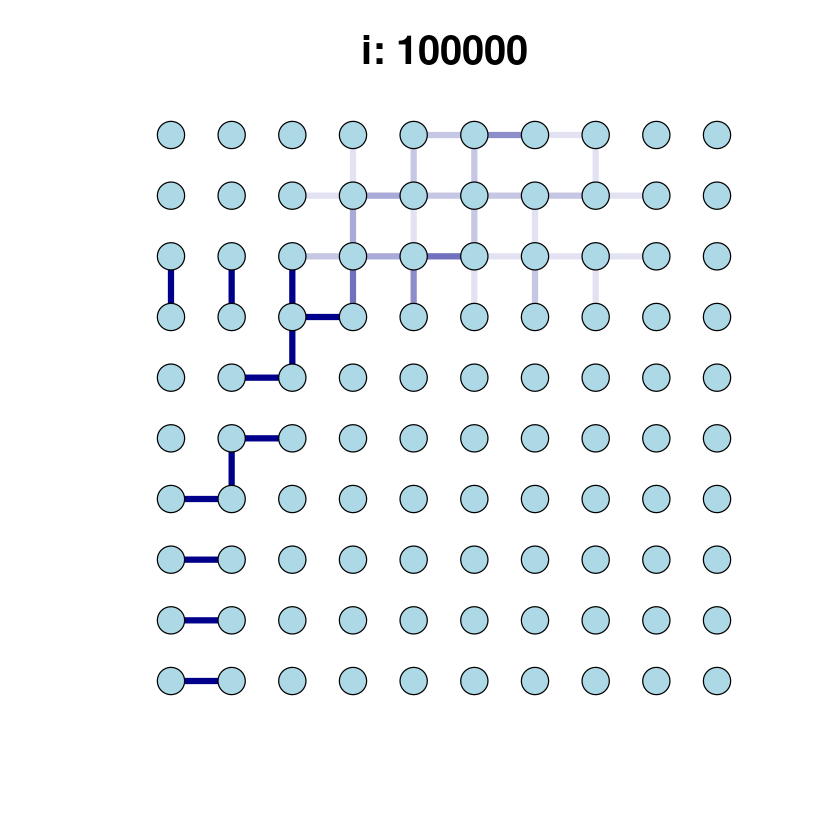

In [43]:
## Dynamics ##
snapshots <- c(1, 1000, 10000, 100000)

# Initialize the progress bar
total_steps <- max(snapshots)
pb <- txtProgressBar(min = 1, max = total_steps, style = 3)

# Loop
for (i in 1:total_steps) {
  if (i %in% snapshots) {
    plotState(g, edge_cmap, i)
  }
  # Perform a single step of the dynamics
  g <- single_step(g)
  
  setTxtProgressBar(pb, i)
}

close(pb) # Close the progress bar

## Analysis

In [43]:
# Load res from csv
res <- read.csv("resultspy2.csv")

In [44]:
sprintf("Unique q values: %s", paste(unique(res$q), collapse = ", "))
sprintf("Unique F values: %s", paste(unique(res$F), collapse = ", "))
sprintf("Unique L values: %s", paste(unique(res$L), collapse = ", "))

[1] "Unique q values: 1, 10, 100, 200, 300, 500"

[1] "Unique F values: 2, 5, 10"

[1] "Unique L values: 50"

In [45]:
# Filter the results and summarize the Monte Carlo simulations
df <- res |>
  filter (L == 50, F == 10) |>
  group_by(q, iteration) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )

tail(df)

q,iteration,s_avg,s_sd,n_avg,n_sd
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
500,2335721469,0.004800000,0.0000000000,0.01462585,0.004364358
500,2976351441,0.003600000,0.0004000000,0.01367347,0.001241380
500,3792690190,0.004133333,0.0006110101,0.01510204,0.003587428
500,4832930238,0.004666667,0.0002309401,0.01462585,0.002143667
500,6158482110,0.005466667,0.0011547005,0.01428571,0.002040816
500,7847599703,0.004533333,0.0002309401,0.01442177,0.002755732


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 36 rows containing non-finite outside the scale range
(`stat_smooth()`).”


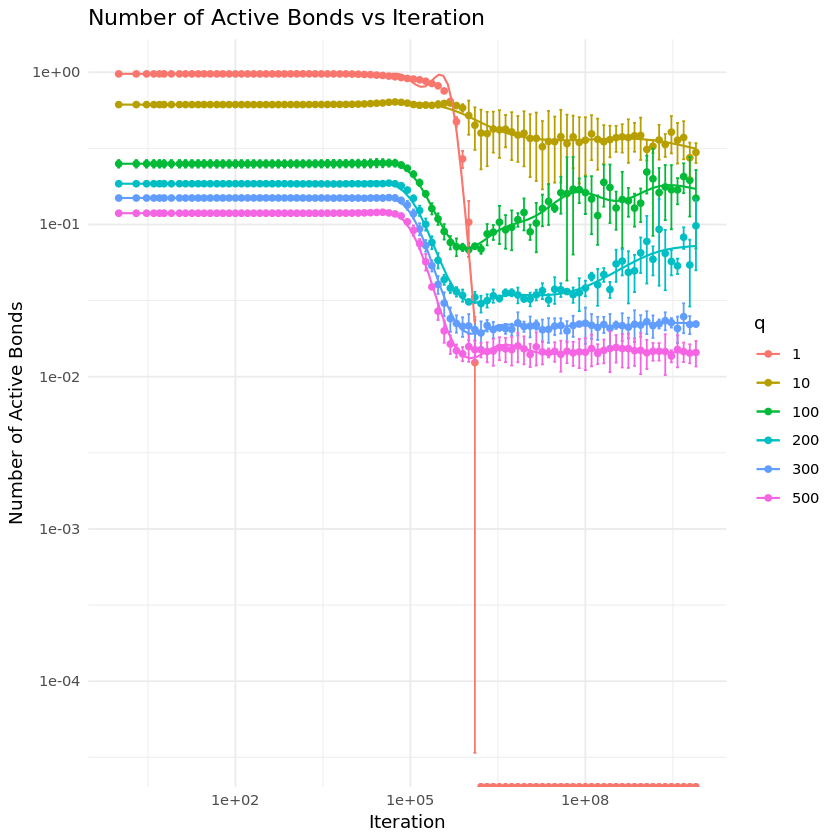

In [46]:
# Plot number of active bonds vs iteration per each q
ggplot(df, aes(x = iteration, y = n_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), width = 0.05) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=15), se = FALSE, linewidth = 0.6) + # Smooth line
  scale_x_log10() +  # Log scale for x-axis
  scale_y_log10() +  # Log scale for y-axis
  labs(
    title = "Number of Active Bonds vs Iteration",
    x = "Iteration",
    y = "Number of Active Bonds",
    color = "q"
  ) +
  theme_minimal()

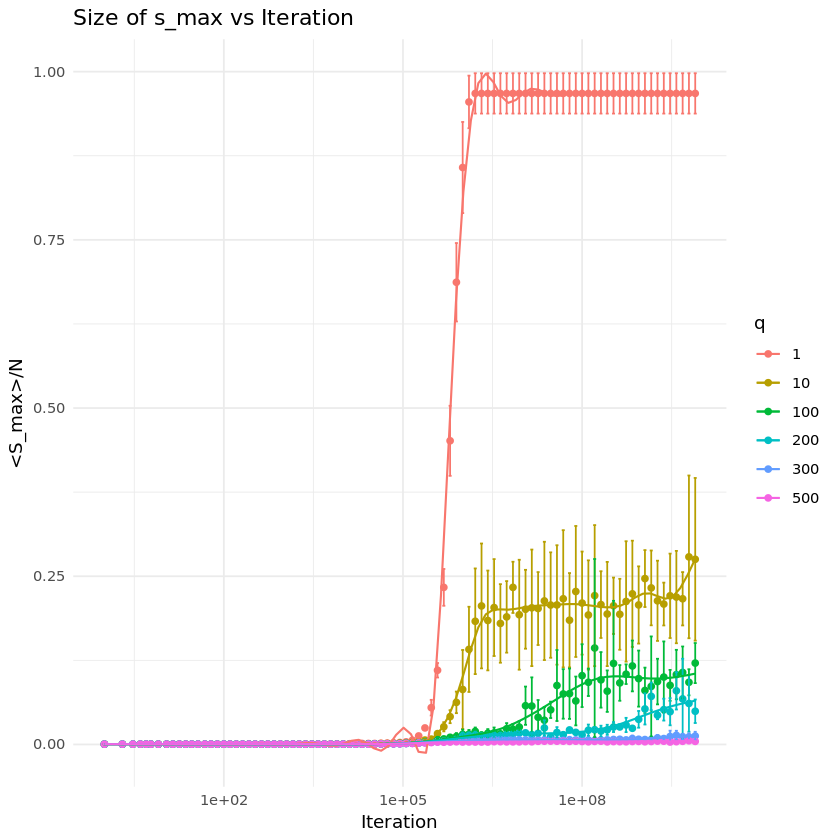

In [47]:
# Plot number of s_max vs iteration per each q
ggplot(df, aes(x = iteration, y = s_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=25), se = FALSE, linewidth = 0.6) +
  scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs Iteration",
    x = "Iteration",
    y = "<S_max>/N",
    color = "q"
  ) +
  theme_minimal()

In [48]:

df <- res |>
  filter(iteration == max(iteration), L == 50) |>
  group_by(q, F) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )  
  
df

q,F,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.088266667,0.0136137186,0.1290476190,0.0248815045
1,5,0.501333333,0.1476028907,0.1304761905,0.0811234972
1,10,0.967600000,0.0299946662,0.0000000000,0.0000000000
10,2,0.006133333,0.0008326664,0.0228571429,0.0008163265
10,5,0.068400000,0.0501182601,0.3764625850,0.0525391638
10,10,0.275200000,0.1209052522,0.2976870748,0.0443201847
100,2,0.002000000,0.0000000000,0.0036054422,0.0007167111
100,5,0.004133333,0.0016165808,0.0173469388,0.0035406840
100,10,0.120933333,0.0297787396,0.1488435374,0.0793308997


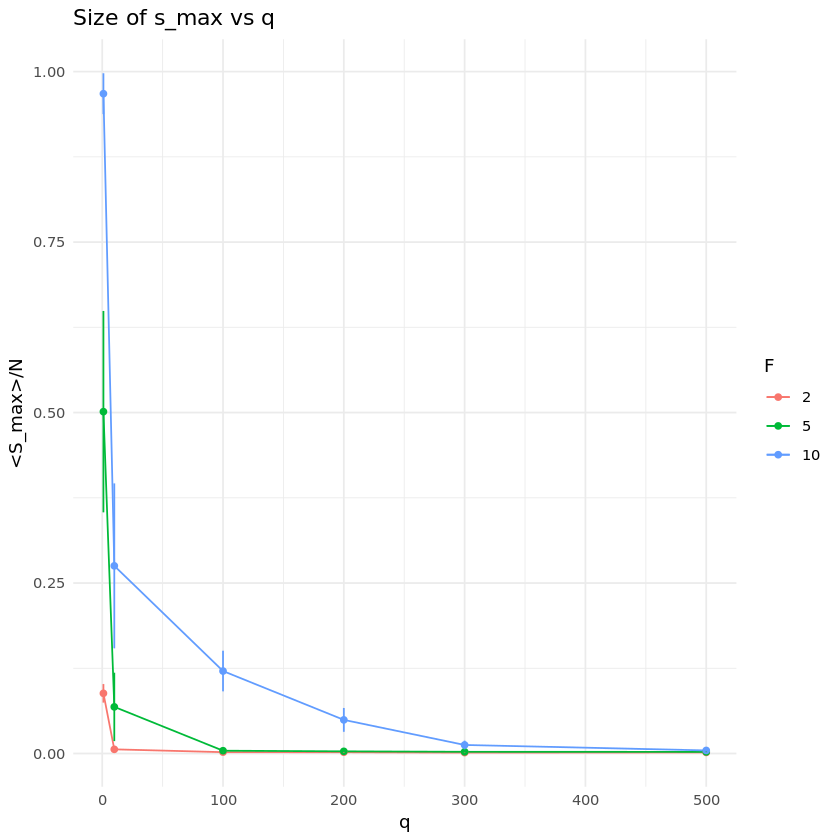

In [49]:
# Plot number of s_max vs q per each L
ggplot(df, aes(x = q, y = s_avg, color = factor(F))) +
  geom_line() +  # Line plot for the mean values
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  #geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=1), se = FALSE, linewidth = 0.6) +
  # scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs q",
    x = "q",
    y = "<S_max>/N",
    color = "F"
  ) +
  theme_minimal()

In [33]:
res <- read.csv("./temp_data/BA_1.csv")
sprintf("Unique q values: %s", paste(unique(res$q), collapse = ", "))
sprintf("Unique F values: %s", paste(unique(res$F), collapse = ", "))

[1] "Unique q values: 1, 2, 4, 6, 8, 10, 100, 200"

[1] "Unique F values: 2, 10"

In [34]:
# Filter the results and summarize the Monte Carlo simulations
df <- res |>
  filter (F == 2) |>
  group_by(q, iteration) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )

tail(df)

q,iteration,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
200,19668038,0.00925,0.0009574271,0,0
200,23702974,0.00925,0.0009574271,0,0
200,28565684,0.00925,0.0009574271,0,0
200,34425988,0.00925,0.0009574271,0,0
200,41488545,0.00925,0.0009574271,0,0
200,49999999,0.00925,0.0009574271,0,0


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in transformation$transform(x):
“NaNs produced”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 341 rows containing non-finite outside the scale range
(`stat_smooth()`).”


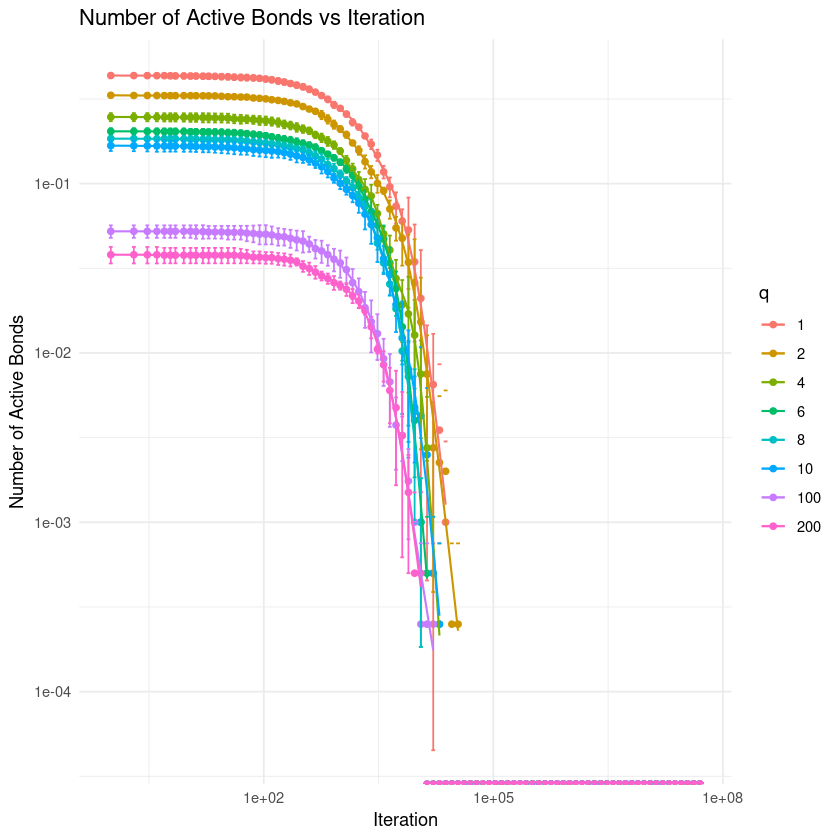

In [35]:
# Plot number of active bonds vs iteration per each q
ggplot(df, aes(x = iteration, y = n_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), width = 0.05) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=15), se = FALSE, linewidth = 0.6) + # Smooth line
  scale_x_log10() +  # Log scale for x-axis
  scale_y_log10() +  # Log scale for y-axis
  labs(
    title = "Number of Active Bonds vs Iteration",
    x = "Iteration",
    y = "Number of Active Bonds",
    color = "q"
  ) +
  theme_minimal()

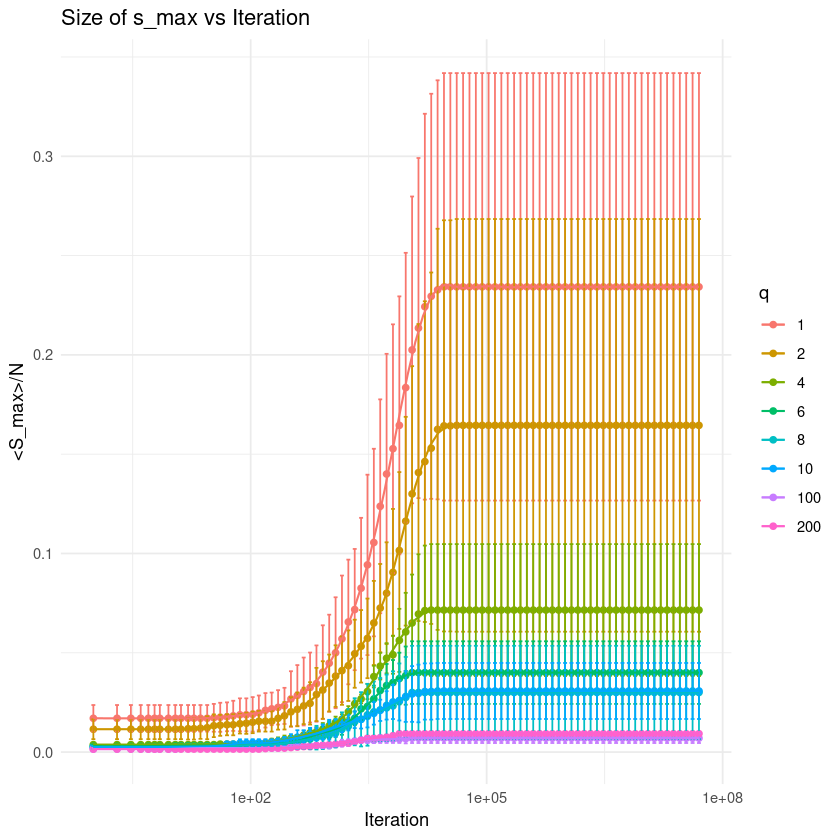

In [36]:
# Plot number of s_max vs iteration per each q
ggplot(df, aes(x = iteration, y = s_avg, color = factor(q))) +
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=25), se = FALSE, linewidth = 0.6) +
  scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs Iteration",
    x = "Iteration",
    y = "<S_max>/N",
    color = "q"
  ) +
  theme_minimal()

In [8]:

df <- res |>
  filter(iteration == max(iteration)) |>
  group_by(q, F) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den), 
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  )  
  
df

q,F,s_avg,s_sd,n_avg,n_sd
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,0.16700,0.0228181215,0.326624497,0.0108015286
1,10,0.02000,0.0021602469,0.898648649,0.0063753760
2,2,0.07100,0.0139283883,0.242524439,0.0081678394
2,10,0.01850,0.0038729833,0.842869465,0.0093507152
4,2,0.03000,0.0135646600,0.162880966,0.0074626479
4,10,0.01875,0.0055000000,0.748921794,0.0164288238
6,2,0.03150,0.0108474267,0.124568718,0.0134989767
6,10,0.01925,0.0030956959,0.668775158,0.0100783041
8,2,0.01700,0.0031622777,0.104082806,0.0061711175


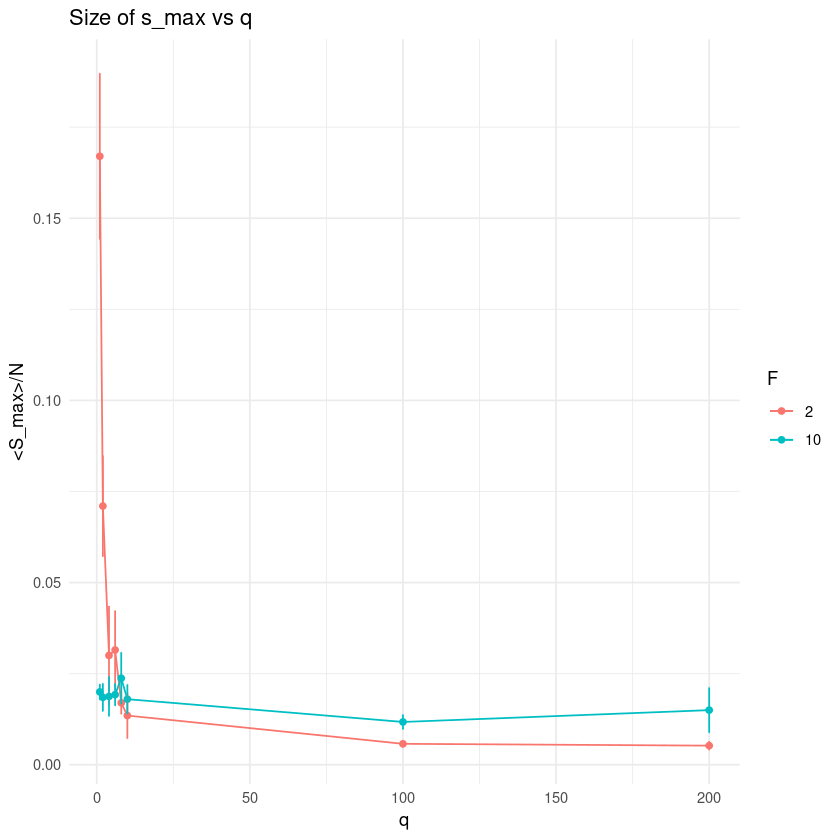

In [9]:
# Plot number of s_max vs q per each L
ggplot(df, aes(x = q, y = s_avg, color = factor(F))) +
  geom_line() +  # Line plot for the mean values
  geom_point() +  # Line plot for the mean values
  geom_errorbar(aes(ymin=(s_avg-s_sd), ymax=(s_avg+s_sd), width = 0.05)) +  # Error bars
  #geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs", k=1), se = FALSE, linewidth = 0.6) +
  # scale_x_log10() +  # Log scale for x-axis
  labs(
    title = "Size of s_max vs q",
    x = "q",
    y = "<S_max>/N",
    color = "F"
  ) +
  theme_minimal()

### Other

In [68]:
labels <- c("BA_1", "BA_5", "ER_0-002", "ER_0-007", "ER_0-012")
q_values <- c(1, 10, 100, 200)
F_value <- 10

labels2 <- c("BA m=1", "BA m=5", "ER p=0.002", "ER p=0.007", "ER p=0.012")

In [30]:
label = "a"

In [31]:
d <- read.csv(file_paths[[1]])

df <- d |>
  filter (F == F_value) |>
  filter (iteration == max(iteration)) |>
  filter (q %in% q_values) |>

  group_by(q) |>
  summarize(
    s_avg=mean(s_max_den), s_sd=sd(s_max_den),
    n_avg=mean(n_density), n_sd=sd(n_density),
    .groups = 'drop'
  ) |>
  mutate (Label = label)

In [32]:
df

q,s_avg,s_sd,n_avg,n_sd,Label
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.86475,0.217754258,0,0,a
10,0.33250,0.147009070,0,0,a
100,0.04850,0.019974984,0,0,a
200,0.03375,0.009535023,0,0,a


In [39]:
preprocess_data <- function(df, label, F_value, q_values) {
  d <- df |>
    filter (F == F_value) |>
    filter (iteration == max(iteration)) |>
    filter (q %in% q_values) |>
    group_by(q) |>
    summarize(
      s_avg=mean(s_max_den), s_sd=sd(s_max_den),
      n_avg=mean(n_density), n_sd=sd(n_density),
      .groups = 'drop'
    ) |>
    mutate (Label = label)
  return(d)
}

In [69]:
# Load and preprocess the data
file_paths <- lapply(labels, function(x) paste0("../../data/task_30/", x, ".csv"))
data_list <- lapply(file_paths, function(x) read.csv(x))

processed_data_list <- map2(data_list,
                            labels2,
                            ~preprocess_data(.x, .y, F_value = F_value, q_values = q_values))
                            
final_data <- bind_rows(processed_data_list)
final_data$q <- factor(final_data$q)

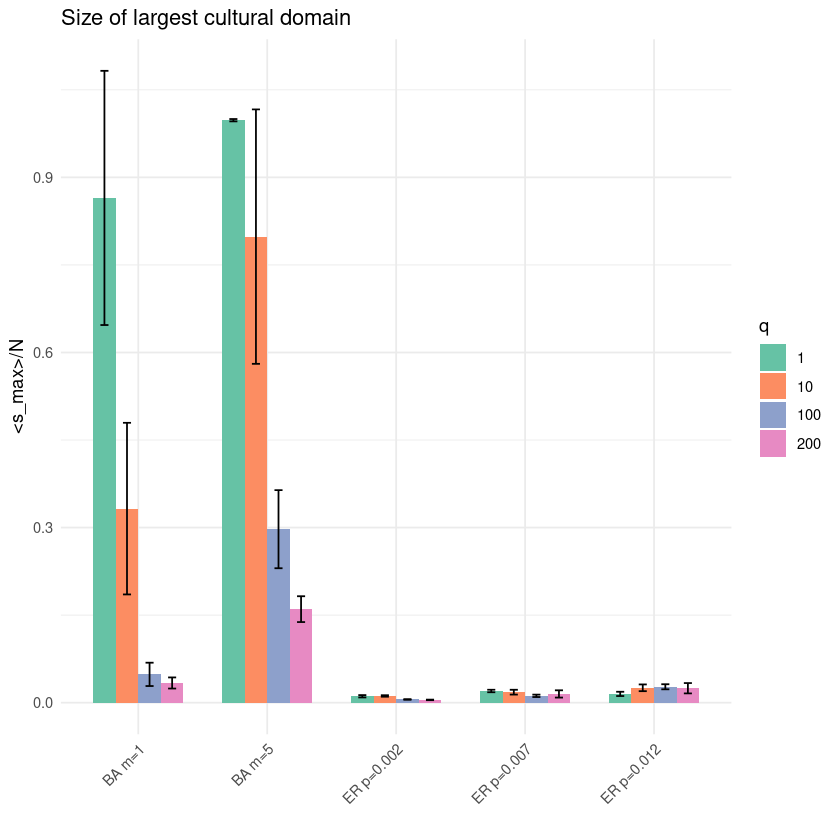

In [75]:
# Create the grouped barplot with error bars
ggplot(final_data, aes(x = Label, y = s_avg, fill = q)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  
  # Add error bars
  geom_errorbar(aes(ymin = s_avg - s_sd, ymax = s_avg + s_sd), 
                position = position_dodge(0.7), width = 0.25) +
  
  labs(title = "Size of largest cultural domain",
       x = "", y = "<s_max>/N") +
  
  scale_fill_brewer(palette = "Set2") +  # Custom color palette
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


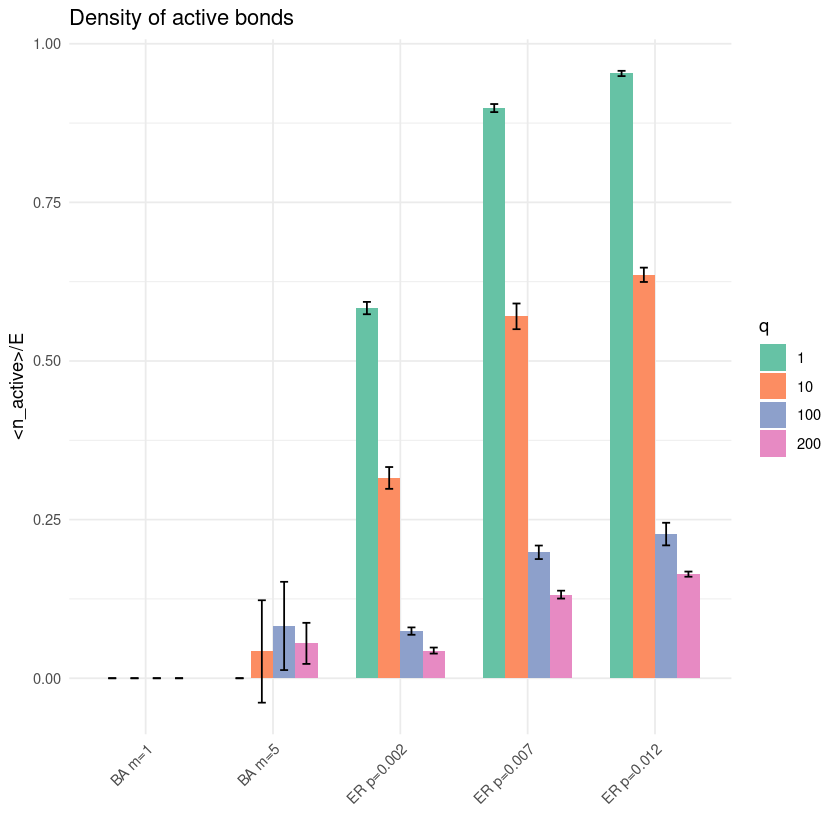

In [76]:
# Create the grouped barplot with error bars
ggplot(final_data, aes(x = Label, y = n_avg, fill = q)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  
  # Add error bars
  geom_errorbar(aes(ymin = n_avg - n_sd, ymax = n_avg + n_sd), 
                position = position_dodge(0.7), width = 0.25) +
  
  labs(title = "Density of active bonds",
       x = "", y = "<n_active>/E") +
  
  scale_fill_brewer(palette = "Set2") +  # Custom color palette
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


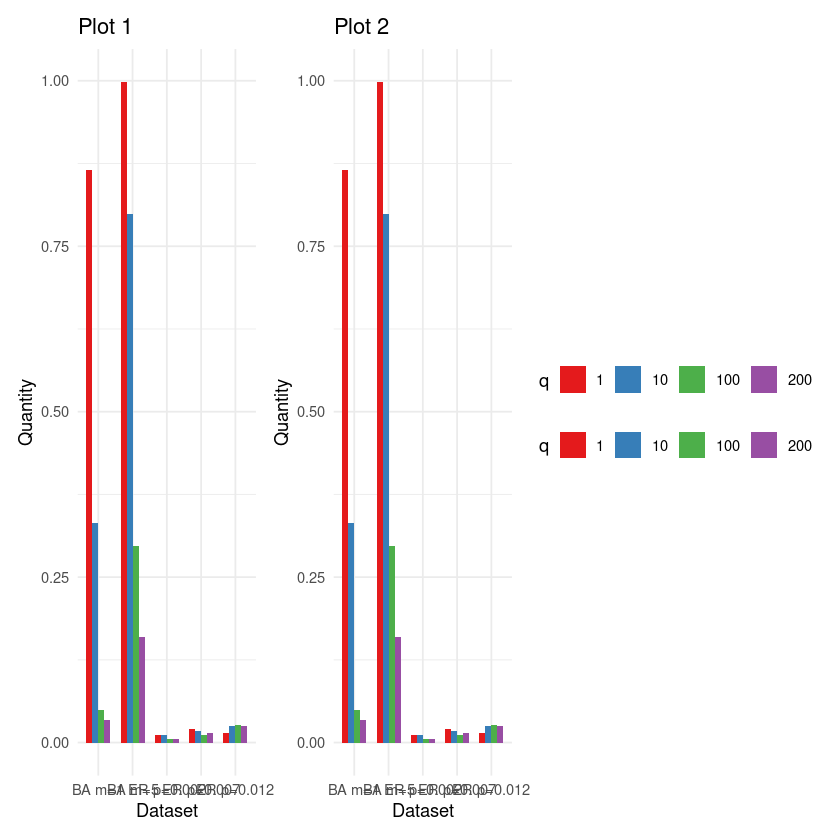

In [103]:
library(ggplot2)
library(patchwork)

# Create two example plots
p1 <- ggplot(final_data, aes(x = Label, y = s_avg, fill = q)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  labs(title = "Plot 1", x = "Dataset", y = "Quantity") +
  scale_fill_brewer(palette = "Set1",  guide = guide_legend(ncol = 4, direction="horizontal")) +
  theme_minimal()

p2 <- ggplot(final_data, aes(x = Label, y = s_avg, fill = q)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  labs(title = "Plot 2", x = "Dataset", y = "Quantity") +
  scale_fill_brewer(palette = "Set1") +
  theme_minimal()

# Combine the plots and share a legend
combined_plot <- p1 + p2 + plot_layout(guides = "collect") + theme(legend.position = "bottom")

# Display the combined plot
print(combined_plot)


Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


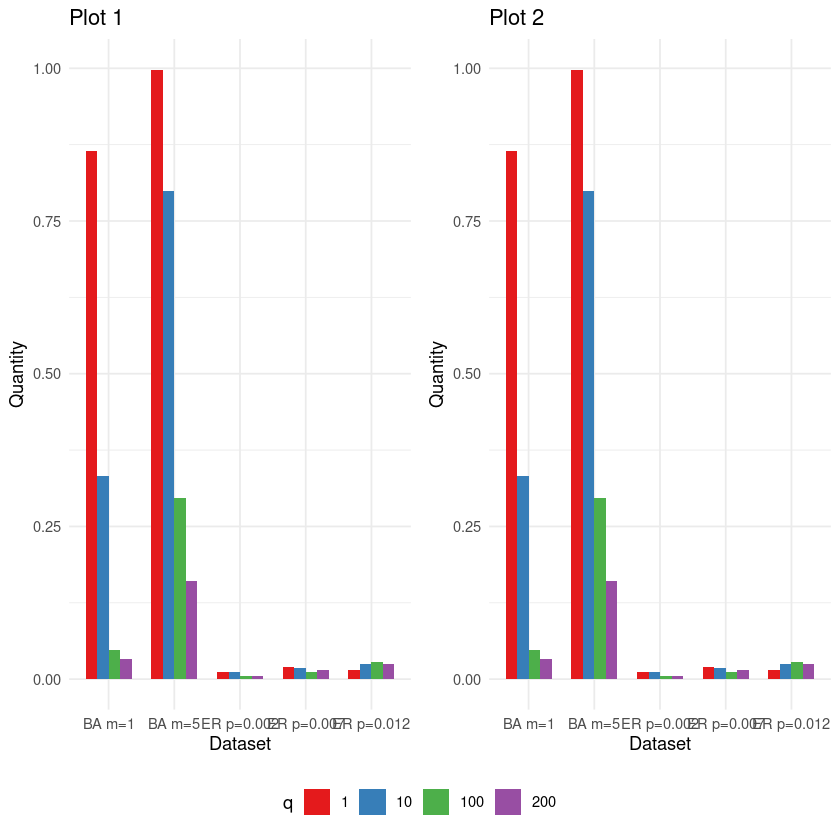

In [104]:
library(cowplot)
# Extract the legend from one of the plots
legend <- get_legend(p1)

# Remove legends from the individual plots
p1 <- p1 + theme(legend.position = "none")
p2 <- p2 + theme(legend.position = "none")

# Combine the plots with a shared legend below
combined_plot <- plot_grid(p1, p2, ncol = 2)  # Combine the plots
final_plot <- plot_grid(combined_plot, legend, ncol = 1, rel_heights = c(1, 0.1))  # Add the legend at the bottom

# Display the combined plot
print(final_plot)